In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    target = []
    for i, sample in f_df.iterrows():
        print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

def load_audio_blockwise(data, blocksize=1024, overlap=512):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [12]:
c_data, targets = load_fold_audio_blockwise(1, dataset, 44100, 5512)
print(c_data.shape)

File Processing.Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing....Done
File Processing......Done
File Processing......Done
File Processing..Done
File Processing..Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing.Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File P

File Processing......Done
File Processing....Done
File Processing......Done
File Processing......Done
File Processing...Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing.....Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing.....Done
File Processing.....Done
File Processing....Done
File Processing.....Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing......Done
File Processing...Done
File Processing......Done


In [13]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
import keras.metrics as kmet
from keras.regularizers import l2
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(sr=44100, input_shape=(1, 44100)))
    model.add(Convolution2D(32, 16, 16, border_mode='valid', name='conv1'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(0.01)))
    
    # Compile model
    model.compile(loss='hinge',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

def gpu_mfcc_shallow_mdn():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(sr=44100, input_shape=(1, 44100)))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(mdn.MDN(1,10))
    
    # Compile model
    model.compile(loss=mdn.get_mixture_loss_func(1, 10),
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [22]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys

In [23]:
r_train_X, r_train_y = balanced_subsample(train_X, train_y)

In [24]:
print(r_train_X.shape)
print(r_train_y.shape)

(1298, 1, 44100)
(1298,)


In [38]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=20, batch_size=128, validation_split=0.15)
history = clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_7 (Melspectro (None, 128, 173, 1)       296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 113, 158, 32)      8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 9, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total para

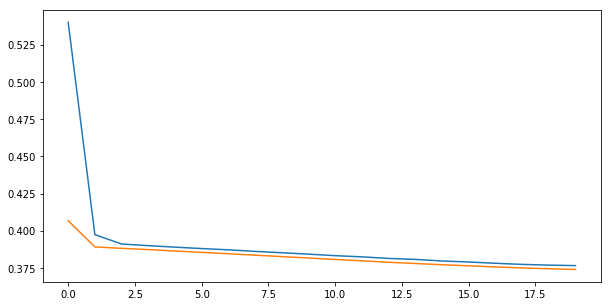

In [39]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
0.631578947368421
Confusion matrix, without normalization
[[  0 161]
 [  0 276]]


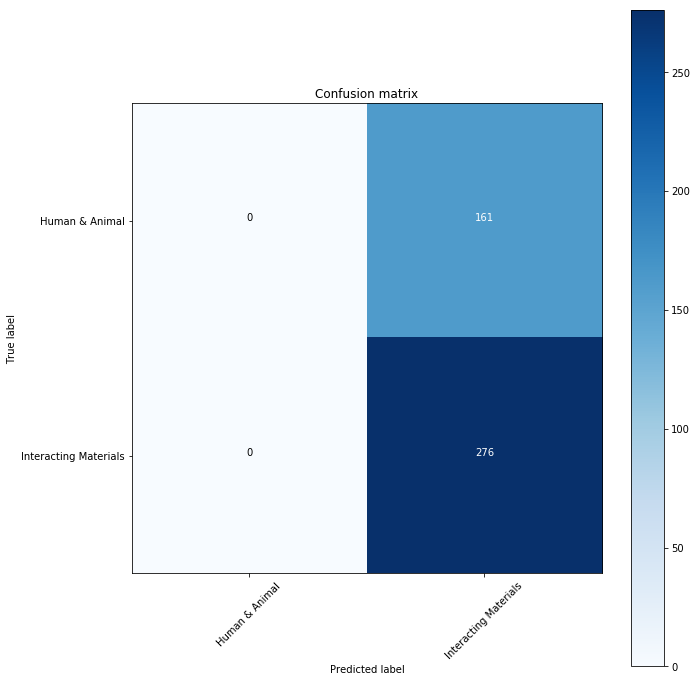

In [41]:
pred = clas.predict(test_X)
print(pred[:20])
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [16]:
def sample_from_output(params, output_dim, num_mixes, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:num_mixes*output_dim]
    sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
    pis = mdn.softmax(params[-num_mixes:], t=temp)
    m = mdn.sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m*output_dim:(m+1)*output_dim]
    sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
    cov_matrix = np.identity(output_dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [ ]:
pred = clas.predict_proba(test_X)
y_samples = np.apply_along_axis(sample_from_output, 1, pred, 1, 10, temp=1.0)
print(y_samples.shape)
print(y_samples)

In [ ]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()